#### The aim of this notebook is twofold - 
1. To give some insights on EgoDataset and AgentDataset, which I believe would help one gain an intuition about the input data to the model. The data in this competitions is a bit complex and I found L5kit to be an amazing tool but a blackbox. So hope this clarifies a few things.
2. Raise certain question about what is the 'image' in a frame of EgoDataset or AgentDataset.

So, let's begin.

# Imports and Configs

In [ ]:
import numpy as np
import os
import torch

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18
from tqdm import tqdm
from typing import Dict

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython.core.display import HTML
import PIL
from matplotlib import animation, rc

In [ ]:
DIR_INPUT = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

SINGLE_MODE_SUBMISSION = f"{DIR_INPUT}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DIR_INPUT}/multi_mode_sample_submission.csv"

DEBUG = True

In [ ]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 4
    },
    
    'train_params': {
        'max_num_steps': 100 if DEBUG else 10000,
        'checkpoint_every_n_steps': 5000,
        
        # 'eval_every_n_steps': -1
    }
}

In [ ]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

# Util Functions

In [ ]:
def animate_solution(images, timestamps=None):
    def animate(i):
        changed_artifacts = [im]
        im.set_data(images[i])
        if timestamps is not None:
            time_text.set_text(timestamps[i])
            changed_artifacts.append(im)
        return tuple(changed_artifacts)

    
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    if timestamps is not None:
        time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes)

    anim = animation.FuncAnimation(fig, animate, frames=len(images), interval=60, blit=True)
    
    # To prevent plotting image inline.
    plt.close()
    return anim

def create_animate_for_indexes(dataset, indexes):
    images = []
    timestamps = []

    for idx in indexes:
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, rgb_color=TARGET_POINTS_COLOR,  yaws=data["target_yaws"])
        clear_output(wait=True)
        images.append(PIL.Image.fromarray(im[::-1]))
        timestamps.append(data["timestamp"])

    anim = animate_solution(images, timestamps)
    return anim

def create_animate_for_scene(dataset, scene_idx):
    indexes = dataset.get_scene_indices(scene_idx)
    return create_animate_for_indexes(dataset, indexes)

# Understanding AgentDataset and EgoDataset

I will use train.zarr here which has

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

#### Let's understand the high-level structure of each Agent and Ego Dataset. Thanks to @[corochann](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library/notebook#1.-Understanding-Rasterizer-class) for this.
### EgoDataset
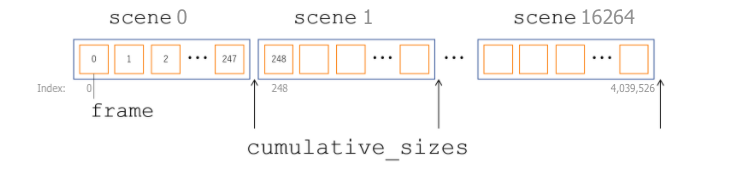
1. Here the subject is the ego car (all the data is for the ego car)
2. EgoDataset (for train.zarr) has a total length of 4,039,527 and each element is a frame. 
3. There are 16,265 scenes and each scene has around 247-248 frames. 
4. Each element (which is a frame in this case) can be identified by a unique timestamp.

In [ ]:
ego_train_dataset = EgoDataset(cfg, train_zarr, rasterizer)
print(ego_train_dataset)
print("Ego dataset length: ", len(ego_train_dataset))

Before we take a look at AgentDataset, you should understand what the internal data structure of a frame is (Also this is the same for Ego and Agent Dataset)

In [ ]:
data = ego_train_dataset[0]

print("agent_dataset[0]=data is ", type(data))

def _describe(value):
    if hasattr(value, "shape"):
        return f"{type(value).__name__:20} shape={value.shape}"
    else:
        return f"{type(value).__name__:20} value={value}"

for key, value in data.items():
    print("  ", f"{key:25}", _describe(value))

Each attribute represents follows: 
* image: image drawn by Rasterizer. As you saw on the top of this kernel. This is usually be the input image for CNN
* target_positions: The "Ego car" or "Agent (car/cyclist/pedestrian etc)"'s future position. This is the value to predict in this competition (not for Ego car's, but for Agents).
* target_yaws: The Ego car's future yaw, to represent heading direction.
* target_availabilities: flag to represent this is valid or not. Only flag=1 is used for competition evaluation.
* history_positions: Past positions
* history_yaws: Past yaws
* history_availabilities:
* world_to_image: 3x3 transformation matrix to convert world-coordinate into pixel-coordinate.
* track_id: Unique ID for each Agent. None for Ego car.
* timestamp: timestamp for current frame.
* centroid: current center position
* yaw: current direction
* extent: Ego car or Agent's size. The car is not represented as point, but should be cared as dot box to include size information on the map.

### AgentDataset
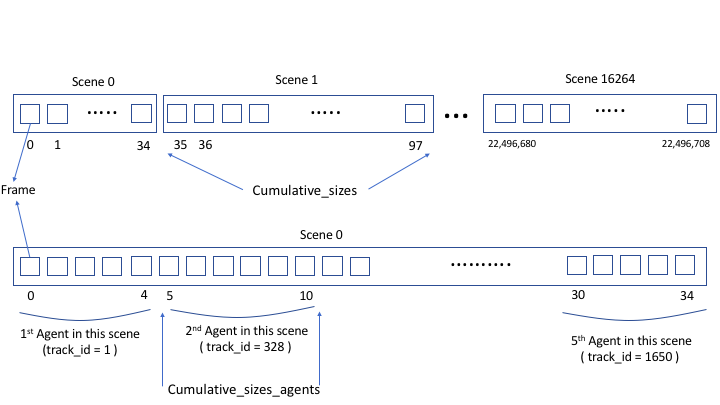

1. Here the subject is the agent car (all the data is for the agent car)
2. AgentDataset (for train.zarr) has a total length of 22,496,709 and each element again is a frame (so the data structure of each element is exactly the same as of EgoDataset). 
3. There are 16,265 scenes and each scene has one of the three-
    *   less number of frames than the corresponding scene in EgoDataset.
    *   equal number of frames than the corresponding scene in EgoDataset.
    *   more number of frames than the corresponding scene in EgoDataset.
    For instance, scene-0 has 35 frames, scene-1 has 63 frames, scene-1001 has 2118 frames.
4. Each element can be identified by a unique (timestamp + track_id) .

In [ ]:
agent_train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
print(agent_train_dataset)
print("Agent dataset length: ", len(agent_train_dataset))

Now, to understand the relation between EgoDataset and AgentDataset, let us consider scene 0. 
Scene 0 in EgoDataset has 248 frames and we can visualize it as follows:

In [ ]:
ego_scene_0 = ego_train_dataset.get_scene_dataset(0)
anim = create_animate_for_indexes(ego_scene_0, np.arange(len(ego_scene_0)))
HTML(anim.to_jshtml())

In [ ]:
# The frames in the scene are in a sequence and each frame has a unique timestamp and has track_id = -1 (-1 is for ego_car)
for i in range(len(ego_scene_0)):
    print("Track ID: ", ego_scene_0[i]['track_id'], " Frame ID: ",  ego_scene_0[i]['timestamp'])


Scene 0 in AgentDataset has 35 frames where the first 5 frames are for agent with track_id=1, next 6 frames for agent with track_id=328 and so on. It is important to note that each element of a scene in the AgentDataset corrsponds to some element in the same scene of EgoDataset. (And this relation can be seen using timestamp as each frame is identified using timestamp)

For instance, the 1st elemet of scene 0 of AgentDataset (track_id=1 and timestamp=1572643685901838786) corresponds to the 12th element of scene 0 of EgoDataset (track_id=-1 and timestamp=1572643685901838786)

In [ ]:
agent_scene_0 = agent_train_dataset.get_scene_dataset(0)

for i in range(len(agent_scene_0)):
    print("Track ID: ", agent_scene_0[i]['track_id'], " Frame ID: ",  agent_scene_0[i]['timestamp'])

To understand this visualization for scene 0 of AgentDataset, press next button one by one (Do not press "play" button). You will notice that the first 5 frames are for **agent_1**, the next 6 frames are for **agent_328** and so on. 

Note: Here the green car is the subject agent car and the blue cars could be other agent cars or the Ego car.

In [ ]:
anim = create_animate_for_indexes(agent_scene_0, np.arange(len(agent_scene_0)))
HTML(anim.to_jshtml())

Hopefully this clarifies what the relation between EgoDataset and AgentDataset is and my first point!

Coming up next: The input to the CNN: (batch_size, 25, 224, 224). What does this 25 (in_channel) denote?